### 참고자료

https://tykimos.github.io/2017/08/17/Text_Input_Binary_Classification_Model_Recipe/

https://tykimos.github.io/2017/03/25/Dataset_and_Fit_Talk/

https://github.com/rickiepark/deep-learning-with-python-notebooks/blob/master/3.4-classifying-movie-reviews.ipynb

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

### 데이터 전처리

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

max_features = 20000
text_max_words = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

전처리는 똑같이 진행한다.

### 모델 설계

In [3]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 256)          98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)      

CNN과 LSTM을 동시에 사용하였다. LSTM의 위치를 보면 max_pooling 뒤에 위치하는 것을 확인할 수 있다. CNN만 있었던 것과 큰 차이인데, CNN만 사용했을 때는 특징을 뽑아낸 데이터를 relu로 이용해 학습하였다. 하지만 여기서는 pool_size를 따로 줘서 max_pooling을 하면서 49개의 특징벡터를 뽑아내어 이를 LSTM을 이용해 학습하고 sigmoid를 이용해 평가한다.

### 학습

In [4]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 34s 2ms/step - loss: 0.4029 - acc: 0.8013 - val_loss: 0.3043 - val_acc: 0.8762
Epoch 2/25
20000/20000 [==============================] - 29s 1ms/step - loss: 0.1881 - acc: 0.9295 - val_loss: 0.3531 - val_acc: 0.8540
Epoch 3/25
20000/20000 [==============================] - 30s 1ms/step - loss: 0.0943 - acc: 0.9684 - val_loss: 0.3988 - val_acc: 0.8634
Epoch 4/25
20000/20000 [==============================] - 29s 1ms/step - loss: 0.0478 - acc: 0.9854 - val_loss: 0.4871 - val_acc: 0.8612
Epoch 5/25
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0343 - acc: 0.9896 - val_loss: 0.5194 - val_acc: 0.8598
Epoch 6/25
20000/20000 [==============================] - 29s 1ms/step - loss: 0.0259 - acc: 0.9920 - val_loss: 0.6782 - val_acc: 0.8552
Epoch 7/25
20000/20000 [==============================] - 27s 1ms/step - loss: 0.

학습 자체는 다른것과 동일하게 진행한다. epochs만 조건에 맞게 25로 설정한다.

### 시각화

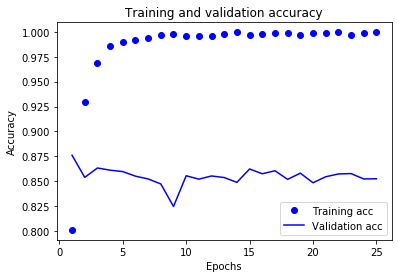

In [8]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습 데이터 정확도는 비교적 높지만, 평가 데이터 정확도는 낮다.

In [6]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print(loss_and_metrics)

25000/25000 [==============================] - 12s 477us/step
[1.2694629144287108, 0.8339200000381469]


In [7]:
model.predict(x_val)

array([[2.4020672e-05],
       [1.2779236e-04],
       [9.8764694e-01],
       ...,
       [2.5331974e-06],
       [9.9999601e-01],
       [9.9996334e-01]], dtype=float32)

시각화 자료에 따르면 평가 정확도가 비교적 낮은데, 모델 예측을 돌려보면 비교적 1과 10 근처로 잘 잡힌 것을 확인할 수 있다.